# Tonemapping an HDR image using Taichi GPU computing interface

### Initialize packages

In [15]:
import numpy as np
import imageio as iio
import matplotlib.pyplot as plt
import taichi as ti
ti.init(arch=ti.gpu)
GUI_DOWNSCALING_FACTOR = 1.0

[Taichi] Starting on arch=cuda


### Load input image data

In [29]:
FILENAME = 'frame25'
iio.plugins.freeimage.download()
image = iio.imread('onset.png', format='PFM-FI')
image.shape, image.dtype

ValueError: Could not load bitmap "/home/a/Projects/generative/creative-coding-collection/001_game_of_life/onset.png": Invalid magic number

### Allocate GPU memory

In [17]:
image_grid = ti.field(dtype=ti.f32, shape=image.shape)
image_grid_downsampled = ti.field(dtype=ti.f32, shape=(int(image.shape[1] / GUI_DOWNSCALING_FACTOR), int(image.shape[0] / GUI_DOWNSCALING_FACTOR), image.shape[2]))
igaussian_grid_A = ti.field(dtype=ti.f32, shape=image.shape)
igaussian_grid_B = ti.field(dtype=ti.f32, shape=image.shape)

### Define GPU compute kernels

In [18]:
@ti.kernel
def copy(dst: ti.template(), src: ti.template()):
    for p in ti.grouped(dst):
        dst[p] = src[p]

@ti.kernel
def tonemap_hdr(exposure: ti.f32, gamma: ti.f32, i_red: ti.f32, i_green: ti.f32, i_blue: ti.f32):
    for x, y in ti.ndrange(image_grid.shape[0], image_grid.shape[1]):
        image_grid[x, y, 0] = (1.0 - ti.exp(-exposure * i_red   * image_grid[x, y, 0])) ** (1.0/gamma)
        image_grid[x, y, 1] = (1.0 - ti.exp(-exposure * i_green * image_grid[x, y, 1])) ** (1.0/gamma)
        image_grid[x, y, 2] = (1.0 - ti.exp(-exposure * i_blue  * image_grid[x, y, 2])) ** (1.0/gamma)

GAUSS = [5.0, 1.0, 1.0/1.41]
GAUSS_NORM = GAUSS[0] + 4.0 * GAUSS[1] + 4.0 * GAUSS[2]

@ti.kernel
# def incremental_blur():
def blur(i_gaussian_grid_1: ti.template(), i_gaussian_grid_2: ti.template()):
    GAUSS = [5.0, 1.0, 1.0/1.41]
    GAUSS_NORM = GAUSS[0] + 4.0 * GAUSS[1] + 4.0 * GAUSS[2]
    for x, y, ch in i_gaussian_grid_2:
        value = GAUSS[0] * i_gaussian_grid_1[x, y, ch]\
              + GAUSS[1] * i_gaussian_grid_1[x-1, y, ch]\
              + GAUSS[1] * i_gaussian_grid_1[x+1, y, ch]\
              + GAUSS[1] * i_gaussian_grid_1[x, y-1, ch]\
              + GAUSS[1] * i_gaussian_grid_1[x, y+1, ch]\
              + GAUSS[2] * i_gaussian_grid_1[x-1, y-1, ch]\
              + GAUSS[2] * i_gaussian_grid_1[x+1, y+1, ch]\
              + GAUSS[2] * i_gaussian_grid_1[x+1, y-1, ch]\
              + GAUSS[2] * i_gaussian_grid_1[x-1, y+1, ch]
        i_gaussian_grid_2[x, y, ch] = value / GAUSS_NORM

@ti.kernel
def unsharp_compose(intensity: ti.f32):
    for x, y, ch in image_grid:
        base = image_grid[x, y, ch]
        blurred = igaussian_grid_A[x, y, ch]
        image_grid[x, y, ch] = max(0.0, min(base + intensity * (base - blurred), 1.0))

@ti.kernel
def img_downsample(img : ti.template(), img_downsampled : ti.template()):
    for x, y, ch in img_downsampled:
        img_downsampled[x, y, ch] =\
            img[int((img.shape[0] - GUI_DOWNSCALING_FACTOR*y)), int(GUI_DOWNSCALING_FACTOR * x), ch]

### Run Taichi GUI and computation

In [19]:
gui = ti.GUI('Game of Life', (image_grid_downsampled.shape[0], image_grid_downsampled.shape[1]))
exposure = gui.slider('exposure', 0.0, 10.0, 0.01); exposure.value = 2.0
gamma = gui.slider('gamma', 0.1, 5.0, 0.01); gamma.value = 1.6
scale = gui.slider('unsharp scale', 0.0, 30.0, 1.0); scale.value = 8.0
sharpness = gui.slider('unsharp intensity', 0.0, 2.0, 0.01); sharpness.value = 0.3
i_red = gui.slider('I-red', 0.0, 2.0, 0.01); i_red.value = 1.1
i_green = gui.slider('I-green', 0.0, 2.0, 0.01); i_green.value = 1.05
i_blue = gui.slider('I-blue', 0.0, 2.0, 0.01); i_blue.value = 1.0


while gui.running:
    # copy image from CPU to GPU memory
    image_grid.from_numpy(image)
    # tonemap image using the gamma operator
    tonemap_hdr(exposure.value, gamma.value, i_red.value, i_green.value, i_blue.value)

    # sharpen the image using unsharp masking with incremental Gaussian blur
    copy(igaussian_grid_A, image_grid)
    for n in range(int(scale.value)):
        # incremental_blur()
        blur(igaussian_grid_A, igaussian_grid_B)
        blur(igaussian_grid_B, igaussian_grid_A)
    unsharp_compose(sharpness.value)

    # downsample the image for display in the GUI
    img_downsample(image_grid, image_grid_downsampled)
    gui.set_image(image_grid_downsampled)
    gui.show()

# when done, copy the results back to the CPU memory
image_final = image_grid.to_numpy()

[Taichi] materializing...


### Show results

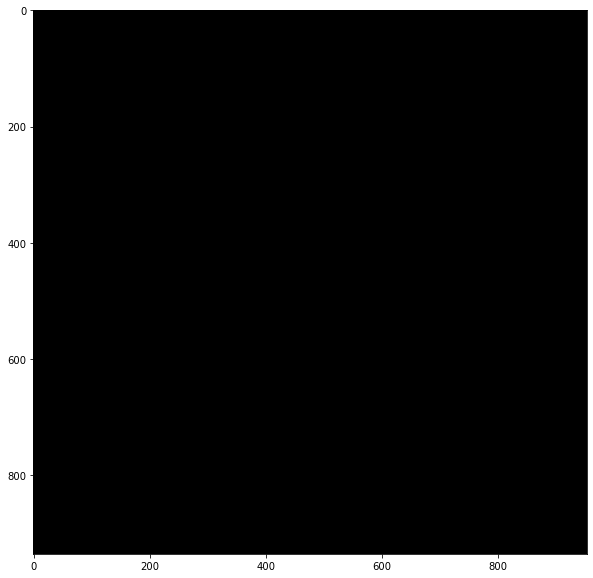

In [20]:
# version 1
# ti.imdisplay(image)
plt.figure(figsize = (10.0, 10.0))
# version 2
plt.imshow(image_final);

### Store results

In [21]:
iio.imwrite(FILENAME + '.exr', image_final, format='EXR-FI')
image_final_LDR = 255.0 * image_final
iio.imwrite(FILENAME + '.png', image_final_LDR.astype(np.uint8), format='PNG-FI')